# Hybrid Measurement-Modeling-based Simulator for HPC-Applicatoin Co-design
* Prepare HPCSim
    - pip install numpy pandas matplotlib ipywidgets jupyterlab
* Run 
    - launch jupyter-lab, and access IDE via browser
    - open hpcsim.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display
%matplotlib inline

In [2]:
class Machine(object):
    def __init__(self, name, num_gpus):
        self.name = name
        self.num_gpus = num_gpus
        self.num_cpus = 2
        self.num_vcores = self.num_cpus*18*2 # vcores = sockets/cores/threads
        self.price = 0
        self.items = {'v100':9000, 'p100':8000, 't4':4000, 'gold':5000}
        if name == 'HGX-1':
            self.gpu_type = 'v100'
            self.cpu_type = 'gold'
            self.bw_h2d = 10*1024**3
            self.bw_d2h = 10*1024**3
            self.bw_p2p = 22*1024**3
            self.bw_net = 100*1024**3/8
            self.gpu_hp_flops = 125*1000**4
            self.gpu_sp_flops = 15.7*1000**4
            self.gpu_dp_flops = 7.8*1000**4
        if name == 'HGX-1-P':
            self.gpu_type = 'p100'
            self.cpu_type = 'gold'           
            self.bw_h2d = 10*1024**3
            self.bw_d2h = 10*1024**3
            self.bw_net = 100*1024**3/8
            self.bw_p2p = 18*1024**3
            self.gpu_hp_flops = 21.2*1000**4
            self.gpu_sp_flops = 10.6*1000**4
            self.gpu_dp_flops = 5.3*1000**4
        if name == 'StarWars':
            self.gpu_type = 't4'
            self.cpu_type = 'gold'
            self.bw_h2d = 10*1024**3
            self.bw_d2h = 10*1024**3
            self.bw_p2p = 10*1024**3
            self.bw_net =  100*1024**3/8
            self.gpu_hp_flops = 65.0*1000**4
            self.gpu_sp_flops = 8.1*1000**4
            self.gpu_dp_flops = 8.1*1000**4
        
        self.price = self.num_gpus * self.items[self.gpu_type] + self.num_cpus * self.items[self.cpu_type]
        
        #Base Spec. for performance/CPV comparison
        self.base_gpu_hp_flops = 125*1000**4
        self.base_gpu_sp_flops = 15.7*1000**4
        self.base_gpu_dp_flops = 7.8*1000**4
        self.base_num_gpus = 8
        self.base_num_cpus = 2*18*2 # vcores = sockets/cores/threads

    def info(self):
        print(self.name)
        print(self.bw_h2d)
        print(self.bw_d2h)
        print(self.bw_net)
        print('')    

In [3]:
class Application(object):
    def __init__(self, name):
        self.name = name
        self.weights = 0
        self.flops = 0
        self.t_fw = 0
        self.t_bw = 0     
        if name == 'resnet50':
            self.weights = 98*1024**2
            self.flops = 3.9*1024**3
            self.t_fw = 0.06
            self.t_bw = 0.12
        if name == 'inceptionv3':
            self.weights = 89*1024**2
            self.flops = 6.0*1024**3
            self.t_fw = 0.09
            self.t_bw = 0.18
        if name == 'resnet152':
            self.weights = 230*1024**2
            self.flops = 11.3*1024**3
            self.t_fw = 0.14
            self.t_bw = 0.28
        if name == 'vgg16':
            self.weights = 528*1024**2
            self.flops = 15.5*1024**3
            self.t_fw = 0.08
            self.t_bw = 0.16
        if name == 'alexnet':
            self.weights = 233*1024**2
            self.flops = 0.7*1024**3
            self.t_fw = 0.01
            self.t_bw = 0.02

In [4]:
class Benchmark(object):    
    def __init__(self, machine, application):
        self.machine = machine
        self.app = application
        self.t_pcie = 0
        self.t_net = 0
        self.t_comm = 0
        self.t_cpu = 0.01
        self.t_gpu = 0
        self.t_step = 0
        self.batch_size = 64
        
    def run(self, strategy):
        if strategy == 'ps':
            self.t_pcie = app.weights / (machine.bw_h2d/machine.num_gpus) + app.weights / (machine.bw_d2h/machine.num_gpus)
            self.t_net = 0
            self.t_p2p = 0
            self.t_comm = self.t_pcie + self.t_net
            self.t_gpu = app.t_fw * machine.base_gpu_sp_flops / machine.gpu_sp_flops
            self.t_step = self.t_cpu + self.t_gpu + self.t_comm 
        elif strategy == 'xring':
            self.t_p2p = 2*(machine.num_gpus-1)*((app.weights/machine.num_gpus) / machine.bw_p2p)
            self.t_net = 0
            self.t_pcie = 0 
            self.t_comm = self.t_pcie + self.t_net
            self.t_gpu = app.t_fw * machine.base_gpu_sp_flops / machine.gpu_sp_flops 
            self.t_step = self.t_cpu + self.t_gpu + self.t_comm 
        self.throughput = machine.num_gpus * self.batch_size / self.t_step
                
    def info(self):
        print(self.name)
        print(self.weights)
        print(self.flops)
        print('')    

In [5]:
machines = []
machines.append( Machine(name='HGX-1', num_gpus=1))
machines.append( Machine(name='HGX-1', num_gpus=8))
machines.append( Machine('StarWars', num_gpus=1))
machines.append( Machine('StarWars', num_gpus=8))

apps = []
apps.append(Application('resnet50'))
apps.append(Application('inceptionv3'))
apps.append(Application('alexnet'))
apps.append(Application('vgg16'))
apps.append(Application('resnet152'))

In [6]:
results = []
_id = 0
for app in apps:   
    base_benchmark = None
    for machine in machines:
        _id = _id + 1
        benchmark = Benchmark(machine, app)
        benchmark.run('ps')
        if machine.name == 'HGX-1' and machine.num_gpus == 1:
            base_benchmark = benchmark 
        speedup = 1
        discount = 1
        #speedup = benchmark.throughput / base_benchmark.throughput
        #discount = benchmark.price / base_benchmark.price
        results.append( [_id,
                         machine.name,
                         machine.num_gpus,
                         app.name,        
                         app.weights,   
                         benchmark.t_cpu, 
                         benchmark.t_gpu, 
                         benchmark.t_comm, 
                         benchmark.t_step, 
                         benchmark.throughput,
                         machine.price,
                         benchmark.throughput/machine.price
                        ])

In [7]:
# sample data
columns = ['ID',
           'Machine',
           'GPUs',
           'Model',
           'ModelSize (MB)',
           'CPU Time (s)',
           'GPU Time (s)',
           'COMM Time (s)',
           'STEP time (s)',
           'Throughput (imgs/s)',
           'Price ($)',
           'C/P value']
df = pd.DataFrame(results, columns=columns)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df.to_csv('report.csv')
print(df)


    ID   Machine  GPUs        Model  ModelSize (MB)  CPU Time (s)  GPU Time (s)  COMM Time (s)  STEP time (s)  Throughput (imgs/s)  Price ($)  C/P value
0    1     HGX-1     1     resnet50       102760448          0.01      0.060000       0.019141       0.089141           717.966696      19000   0.037788
1    2     HGX-1     8     resnet50       102760448          0.01      0.060000       0.153125       0.223125          2294.677871      82000   0.027984
2    3  StarWars     1     resnet50       102760448          0.01      0.116296       0.019141       0.145437           440.053320      14000   0.031432
3    4  StarWars     8     resnet50       102760448          0.01      0.116296       0.153125       0.279421          1832.358545      42000   0.043628
4    5     HGX-1     1  inceptionv3        93323264          0.01      0.090000       0.017383       0.117383           545.224626      19000   0.028696
5    6     HGX-1     8  inceptionv3        93323264          0.01      0.090000   

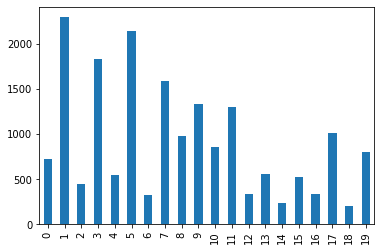

In [8]:
fig = plt.figure()
df['Throughput (imgs/s)'].plot(kind='bar')